# 02 EDA and Media Math
This notebook explores the synthetic campaign data and defines media-math helper
functions such as *reach curves* and *deduped reach approximations*.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", "{:,.2f}".format)

df = pd.read_csv("../data/raw/campaign_daily.csv", parse_dates=["date"])
print("Shape:", df.shape)
df.head()

Shape: (1825, 10)


,date,channel,spend,cpm,impressions,clicks,conversions,est_reach,dow,is_weekend
0,2024-01-01,Display,"17,034.60",9.00,"1,892,733.35","35,378.41",16.73,"181,040.46",0,0
1,2024-01-02,Display,"12,958.56",9.00,"1,439,840.53","28,533.91",12.10,"141,685.10",1,0
2,2024-01-03,Display,"15,738.23",9.00,"1,748,692.18","36,805.41",19.13,"168,773.98",2,0
3,2024-01-04,Display,"18,866.25",9.00,"2,096,249.80","44,912.80",15.68,"197,984.94",3,0
4,2024-01-05,Display,"12,580.80",9.00,"1,397,866.77","28,388.35",24.04,"137,918.99",4,0


In [26]:
df.info()
df.describe().T
df['channel'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1825 non-null   datetime64[ns]
 1   channel      1825 non-null   object        
 2   spend        1825 non-null   float64       
 3   cpm          1825 non-null   float64       
 4   impressions  1825 non-null   float64       
 5   clicks       1825 non-null   float64       
 6   conversions  1825 non-null   float64       
 7   est_reach    1825 non-null   float64       
 8   dow          1825 non-null   int64         
 9   is_weekend   1825 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 142.7+ KB


channel
Display      365
LinearTV     365
Social       365
Streaming    365
YouTube      365
Name: count, dtype: int64

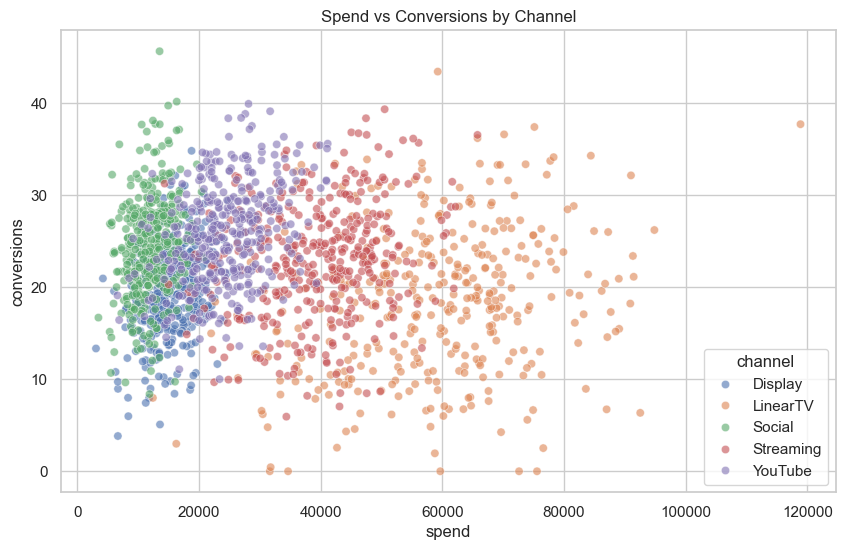

In [27]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="spend", y="conversions", hue="channel", alpha=0.6)
plt.title("Spend vs Conversions by Channel")
plt.show()

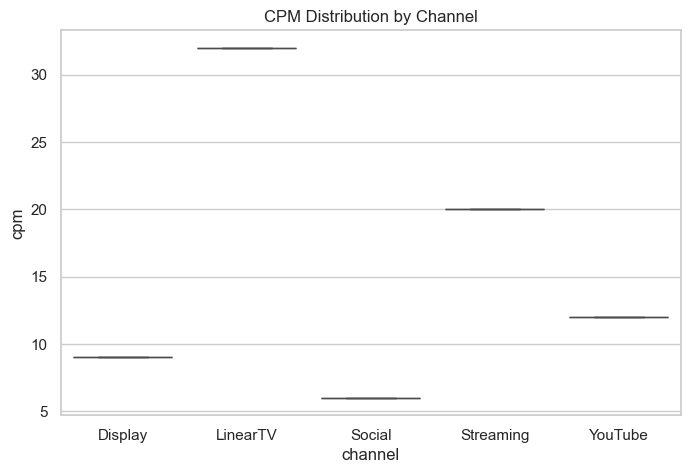

In [28]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="channel", y="cpm")
plt.title("CPM Distribution by Channel")
plt.show()

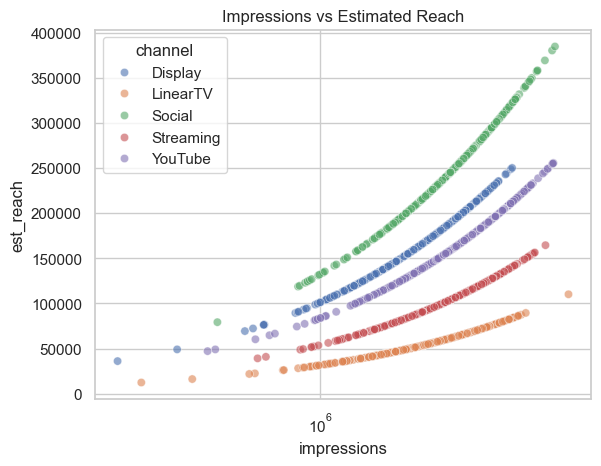

In [29]:
sns.scatterplot(data=df, x="impressions", y="est_reach", hue="channel", alpha=0.6)
plt.title("Impressions vs Estimated Reach")
plt.xscale("log")
plt.show()

In [30]:
def reach_from_impressions(impressions, A=1.0, k=1e-7):
    """
    impressions : number of impressions delivered
    A : asymptotic max fraction of audience reachable (0 < A ≤ 1)
    k : curvature factor controlling saturation speed
    """
    return A * (1 - np.exp(-k * impressions))

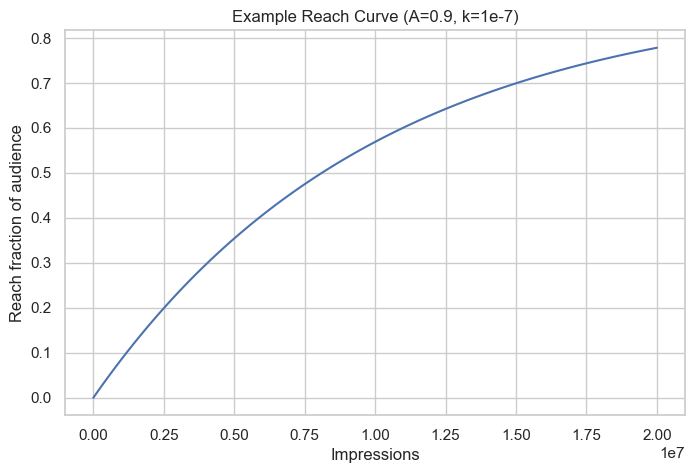

In [31]:
impr = np.linspace(0, 20e6, 100)
plt.figure(figsize=(8,5))
plt.plot(impr, reach_from_impressions(impr, A=0.9, k=1e-7))
plt.xlabel("Impressions")
plt.ylabel("Reach fraction of audience")
plt.title("Example Reach Curve (A=0.9, k=1e-7)")
plt.show()

In [32]:
A, k = 0.8, 1e-7  # tune if you like
df["reach_pct"] = reach_from_impressions(df["impressions"], A, k)
df["reach_people"] = df["reach_pct"] * 1_000_000  # assume 1 M target audience
df.head()

,date,channel,spend,cpm,impressions,clicks,conversions,est_reach,dow,is_weekend,reach_pct,reach_people
0,2024-01-01,Display,"17,034.60",9.00,"1,892,733.35","35,378.41",16.73,"181,040.46",0,0,0.14,"137,951.78"
1,2024-01-02,Display,"12,958.56",9.00,"1,439,840.53","28,533.91",12.10,"141,685.10",1,0,0.11,"107,278.75"
2,2024-01-03,Display,"15,738.23",9.00,"1,748,692.18","36,805.41",19.13,"168,773.98",2,0,0.13,"128,346.55"
3,2024-01-04,Display,"18,866.25",9.00,"2,096,249.80","44,912.80",15.68,"197,984.94",3,0,0.15,"151,289.37"
4,2024-01-05,Display,"12,580.80",9.00,"1,397,866.77","28,388.35",24.04,"137,918.99",4,0,0.10,"104,365.03"


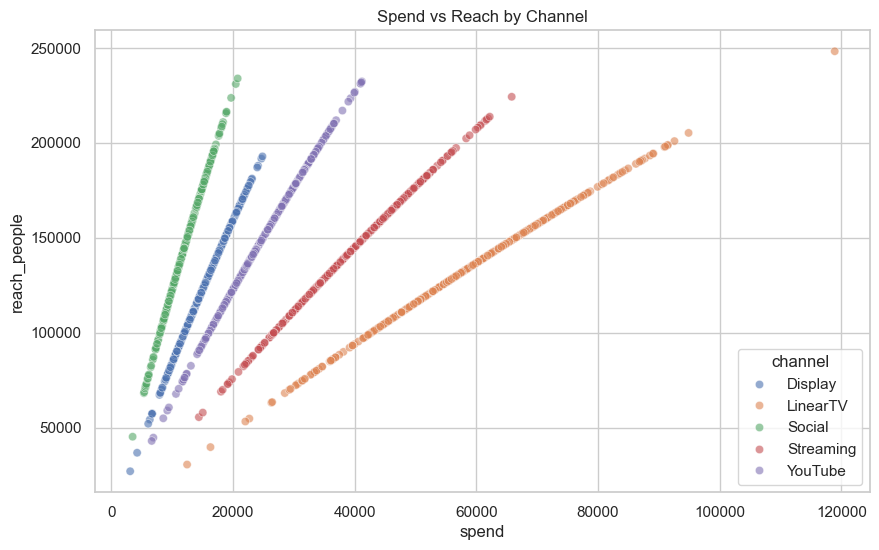

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="spend", y="reach_people", hue="channel", alpha=0.6)
plt.title("Spend vs Reach by Channel")
plt.show()

In [34]:
summary = (df.groupby("channel")[["spend","impressions","clicks","conversions","reach_people"]]
              .mean()
              .round(2))
summary

,spend,impressions,clicks,conversions,reach_people
channel,,,,,
Display,"15,275.42","1,697,269.30","35,138.36",19.42,"124,304.19"
LinearTV,"58,973.81","1,842,931.53","18,545.04",18.51,"133,909.23"
Social,"11,970.68","1,995,113.02","68,263.52",24.44,"143,883.43"
Streaming,"40,018.93","2,000,946.73","34,829.80",22.91,"144,369.70"
YouTube,"24,662.13","2,055,177.59","53,408.50",25.84,"147,719.01"


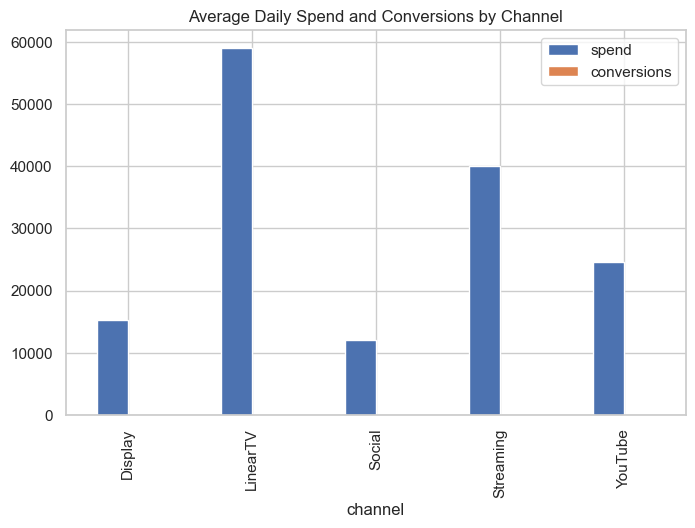

In [35]:
summary[["spend","conversions"]].plot(kind="bar", figsize=(8,5))
plt.title("Average Daily Spend and Conversions by Channel")
plt.show()

In [36]:
df.to_csv("../data/processed/campaign_daily_processed.csv", index=False)
print("Saved processed dataset → data/processed/campaign_daily_processed.csv")

Saved processed dataset → data/processed/campaign_daily_processed.csv
